In [42]:
def install_reqs():
#This defines a function named install_reqs.
    
  !pip install pandas
#Installs the pandas library, used for reading and manipulating tabular data (like .csv, .tsv).
    
  !pip install "matplotlib>=3.4"
#Installs matplotlib version 3.4 or higher, used for plotting graphs and visualizations.
    
  !pip install numpy
#Installs numpy, a fundamental package for numerical computations and arrays.
    
  !pip install statsmodels
#Installs statsmodels, a library used for statistical tests (e.g., t-tests, Wilcoxon), regression, and model fitting.
    
  !pip install scipy
#Installs scipy, which contains scientific computing tools, including statistical and optimization functions.
    
install_reqs()
# to install all the above dependencies uncomment the above line.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab

In [45]:
from matplotlib import __version__ as matplotlibversion
if matplotlibversion < "3.4":
    print("Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays")

Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays


In [46]:
#import os
#os.system(
#    "compass --data expression.tsv "
#    "--model RECON2_mat --species homo_sapiens --media default-media --lambda 0.25 "
#    "--and-function mean --output-dir extdata/APOB --penalty-diffusion knn --num-neighbors 10 "
#    "--isoform-summing legacy --num-processes 50"
#)


In [47]:
import os
print(os.getcwd())


C:\Users\user\Desktop\Harshini\Human dataset_APOB_AIM\4_A vs B


In [48]:
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col=0)

In [49]:
import pandas as pd

# Load reactions.tsv
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col=0)

# Extract cell IDs from the columns
cell_ids = reaction_penalties.columns

# --- NEW FUNCTION: infer group based on suffix after "_" ---
def infer_group(cell_id):
    """
    Extracts the group label from a cell name like '1_A' or '15_C'.
    """
    if "_" in cell_id:
        return cell_id.split("_")[-1]   # A, B, C, or D
    else:
        return "Unknown"

# Create list of inferred groups for each cell
cell_groups = [infer_group(cell) for cell in cell_ids]

# Create metadata DataFrame
cell_metadata = pd.DataFrame({
    "cell_id": cell_ids,
    "group": cell_groups
}).set_index("cell_id")

# Save file
cell_metadata.to_csv("cell_metadata.csv")

print("Created cell_metadata.csv with the following group counts:")
print(cell_metadata["group"].value_counts())

Created cell_metadata.csv with the following group counts:
group
D    38
A    37
B    35
C    34
Name: count, dtype: int64


In [50]:
cell_metadata = pd.read_csv("cell_metadata.csv", sep=",")
cell_metadata.set_index("cell_id", inplace=True)

In [51]:
print(cell_metadata.columns.tolist())  
print(cell_metadata.head())

['group']
        group
cell_id      
1_A         A
2_A         A
3_A         A
4_A         A
5_A         A


In [52]:
# Select cells by group
A_cells = cell_metadata.index[cell_metadata["group"] == "A"]
B_cells = cell_metadata.index[cell_metadata["group"] == "B"]
C_cells = cell_metadata.index[cell_metadata["group"] == "C"]
D_cells = cell_metadata.index[cell_metadata["group"] == "D"]

# Optional: print counts
print("Number of cells per group:")
print("A:", len(A_cells))
print("B:", len(B_cells))
print("C:", len(C_cells))
print("D:", len(D_cells))


Number of cells per group:
A: 37
B: 35
C: 34
D: 38


In [53]:
print(cell_metadata.columns.tolist())


['group']


In [54]:
print(cell_metadata.head())
print(cell_metadata.columns.tolist())

        group
cell_id      
1_A         A
2_A         A
3_A         A
4_A         A
5_A         A
['group']


In [55]:
reaction_metadata = pd.read_csv("reaction_metadata.csv", index_col = 0) 

In [56]:
reaction_metadata.loc[['r0281']]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r0281,Putrescine:oxygen oxidoreductase (deaminating)...,1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putr...,AOC1,Methionine and cysteine metabolism,1.4.3.6,0.0


In [57]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [58]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

In [59]:
common_cells = list(set(reaction_consistencies.columns).intersection(set(cell_metadata.index)))
reaction_consistencies = reaction_consistencies[common_cells]

In [60]:
# Select cells for groups A and B
A_cells = cell_metadata.index[cell_metadata["group"] == "A"]
B_cells = cell_metadata.index[cell_metadata["group"] == "B"]

# Run Wilcoxon test between A and B
wilcox_results = wilcoxon_test(reaction_consistencies, A_cells, D_cells)

# Add metadata reaction ID column
wilcox_results['metadata_r_id'] = ""

for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:  # handles possible suffixes
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur:", r)

# Optional: check the results
print(wilcox_results.head())

                  wilcox_stat  wilcox_pval  cohens_d  adjusted_pval  \
10FTHF5GLUtl_pos        923.0     0.020014  0.586732       0.046661   
10FTHF5GLUtm_pos        857.0     0.103807  0.206941       0.161212   
10FTHF6GLUtl_pos        925.0     0.018911  0.582505       0.044793   
10FTHF6GLUtm_pos        846.0     0.131018  0.267083       0.189929   
10FTHF7GLUtl_pos        920.0     0.021774  0.568015       0.048730   

                 metadata_r_id  
10FTHF5GLUtl_pos  10FTHF5GLUtl  
10FTHF5GLUtm_pos  10FTHF5GLUtm  
10FTHF6GLUtl_pos  10FTHF6GLUtl  
10FTHF6GLUtm_pos  10FTHF6GLUtm  
10FTHF7GLUtl_pos  10FTHF7GLUtl  


In [61]:
print(reaction_consistencies.columns.tolist()[:10])

['11_C', '19_B', '18_C', '27_A', '31_C', '31_A', '40_B', '34_C', '28_D', '25_B']


In [62]:
print(A_cells[:10])

Index(['1_A', '2_A', '3_A', '4_A', '5_A', '6_A', '7_A', '8_A', '9_A', '10_A'], dtype='object', name='cell_id')


In [63]:
# Select cells for groups A and B
A_cells = cell_metadata.index[cell_metadata["group"] == "A"]
B_cells = cell_metadata.index[cell_metadata["group"] == "B"]

# Run the Wilcoxon test between A and B
wilcox_results = wilcoxon_test(reaction_consistencies, A_cells, B_cells)

# Annotate metadata reaction IDs
wilcox_results['metadata_r_id'] = ""

for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:  # handles possible suffixes like '_x'
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print(f"Should not occur → {r}")

# Optional: check the results
print(wilcox_results.head())


                  wilcox_stat  wilcox_pval  cohens_d  adjusted_pval  \
10FTHF5GLUtl_pos        724.0     0.391852  0.215599       0.599567   
10FTHF5GLUtm_pos        692.0     0.620083  0.027687       0.775104   
10FTHF6GLUtl_pos        718.0     0.430308  0.197788       0.634921   
10FTHF6GLUtm_pos        685.0     0.676777  0.052982       0.813003   
10FTHF7GLUtl_pos        722.0     0.404433  0.180496       0.609962   

                 metadata_r_id  
10FTHF5GLUtl_pos  10FTHF5GLUtl  
10FTHF5GLUtm_pos  10FTHF5GLUtm  
10FTHF6GLUtl_pos  10FTHF6GLUtl  
10FTHF6GLUtm_pos  10FTHF6GLUtm  
10FTHF7GLUtl_pos  10FTHF7GLUtl  


In [64]:
# Select cells for groups A and B
A_cells = cell_metadata.index[cell_metadata["group"] == "A"]
B_cells = cell_metadata.index[cell_metadata["group"] == "B"]

# Run the Wilcoxon test between A and B
wilcox_results = wilcoxon_test(reaction_consistencies, A_cells, B_cells)

# Annotate metadata reaction IDs
wilcox_results['metadata_r_id'] = ""

for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:  # handles possible suffixes like '_x'
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print(f"Should not occur → {r}")

# Optional: view top results
print(wilcox_results.head())

                  wilcox_stat  wilcox_pval  cohens_d  adjusted_pval  \
10FTHF5GLUtl_pos        724.0     0.391852  0.215599       0.599567   
10FTHF5GLUtm_pos        692.0     0.620083  0.027687       0.775104   
10FTHF6GLUtl_pos        718.0     0.430308  0.197788       0.634921   
10FTHF6GLUtm_pos        685.0     0.676777  0.052982       0.813003   
10FTHF7GLUtl_pos        722.0     0.404433  0.180496       0.609962   

                 metadata_r_id  
10FTHF5GLUtl_pos  10FTHF5GLUtl  
10FTHF5GLUtm_pos  10FTHF5GLUtm  
10FTHF6GLUtl_pos  10FTHF6GLUtl  
10FTHF6GLUtm_pos  10FTHF6GLUtm  
10FTHF7GLUtl_pos  10FTHF7GLUtl  


In [65]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [66]:
wilcox_results.loc[['r0281_pos']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_pos,675.0,0.760976,0.0466,0.867279,r0281


In [67]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

In [68]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    
    # Visual markers and title
    axs.set_xlim(-8, 8)
    axs.set_ylim(0, 6)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})

    # Arrows for group identity (A vs B)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08), 
                 arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Group A', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
                 arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Group B', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)

    # Dynamic annotation loop with variable offsets and labels
    for i, r in enumerate(data.index):
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])

            dx = 30 if x >= 0 else -120  # horizontal offset
            dy = (i % 6) * 12 - 30       # vertical offset varies to reduce stacking

            axs.annotate(
                labeled_reactions[r],
                (x, y),
                xytext=(dx, dy),
                textcoords='offset pixels',
                arrowprops=dict(arrowstyle="-", shrinkA=6, shrinkB=4),
                fontsize=10,
                zorder=5,  # make sure text is on top
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
            )


In [69]:
filtered_data = pd.concat([
    W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
    W[W['subsystem'] == "Citric acid cycle"],
    W[W['subsystem'].isin(amino_acid_metab)],
    W[W['subsystem'] == "N-glycan synthesis"],
    W[W['subsystem'] == "Fatty acid oxidation"]
])

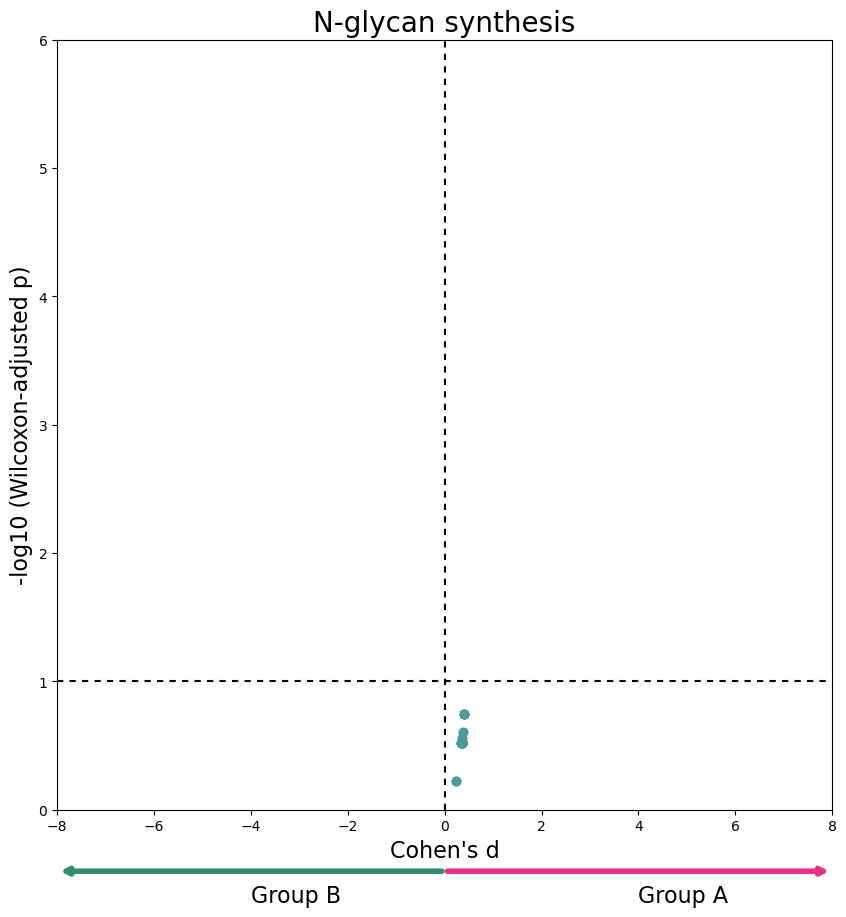

In [70]:
data = W[W['subsystem'] == "N-glycan synthesis"]
plot_differential_scores(data, title='N-glycan synthesis', c="#4C9A9A")

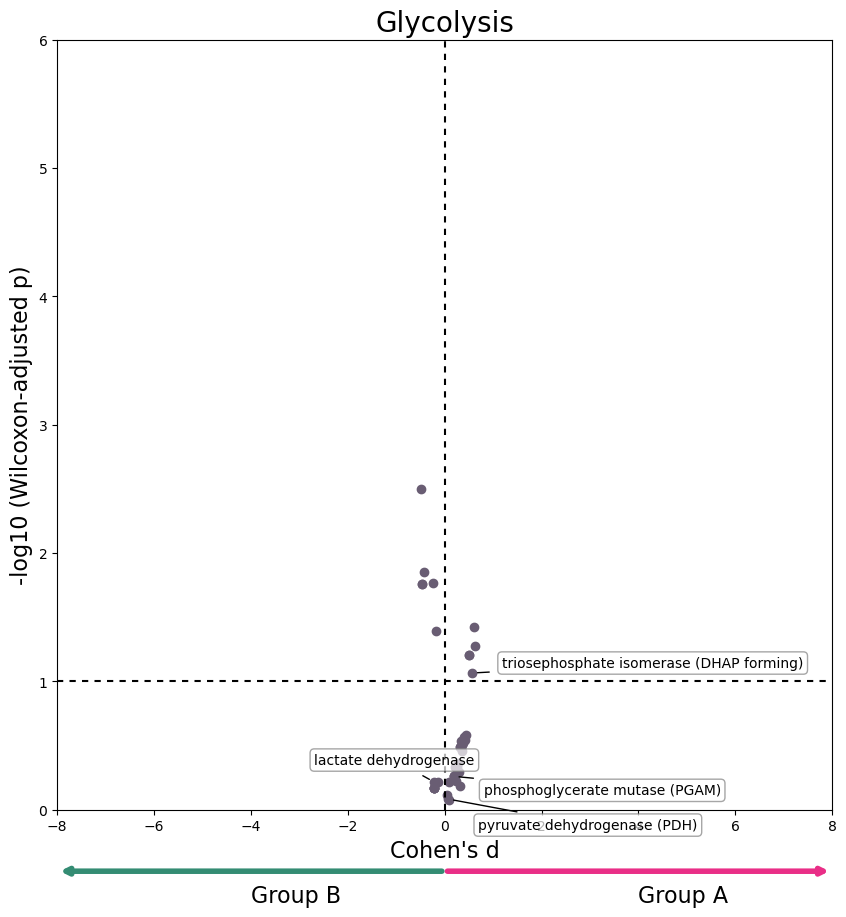

In [71]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

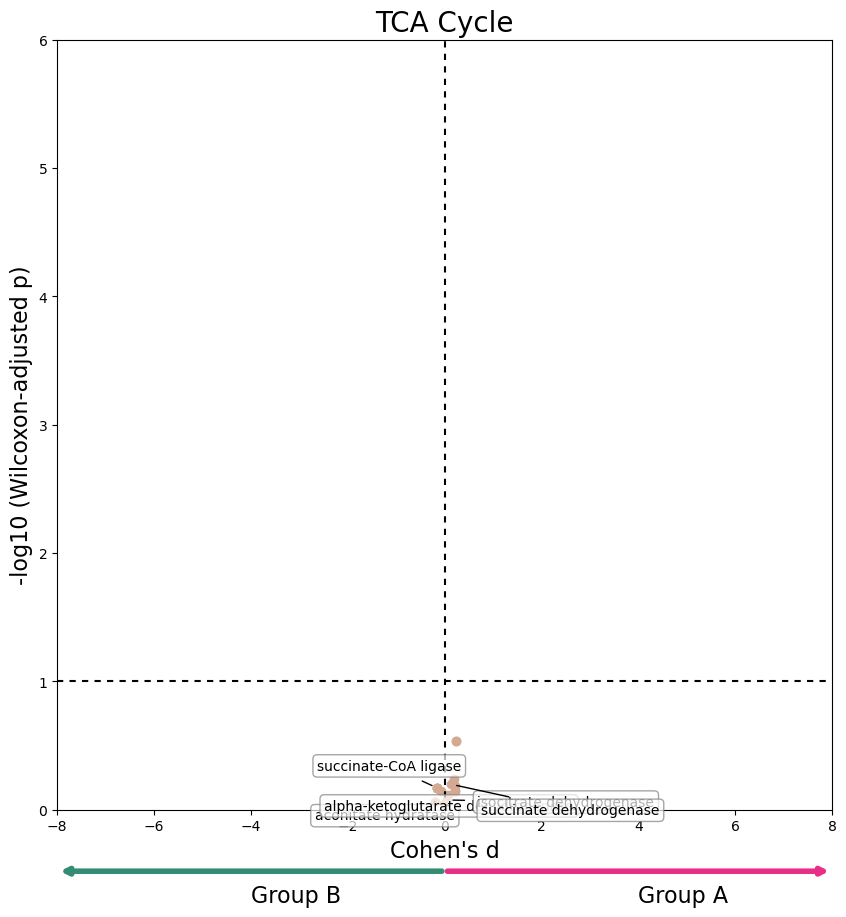

In [72]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

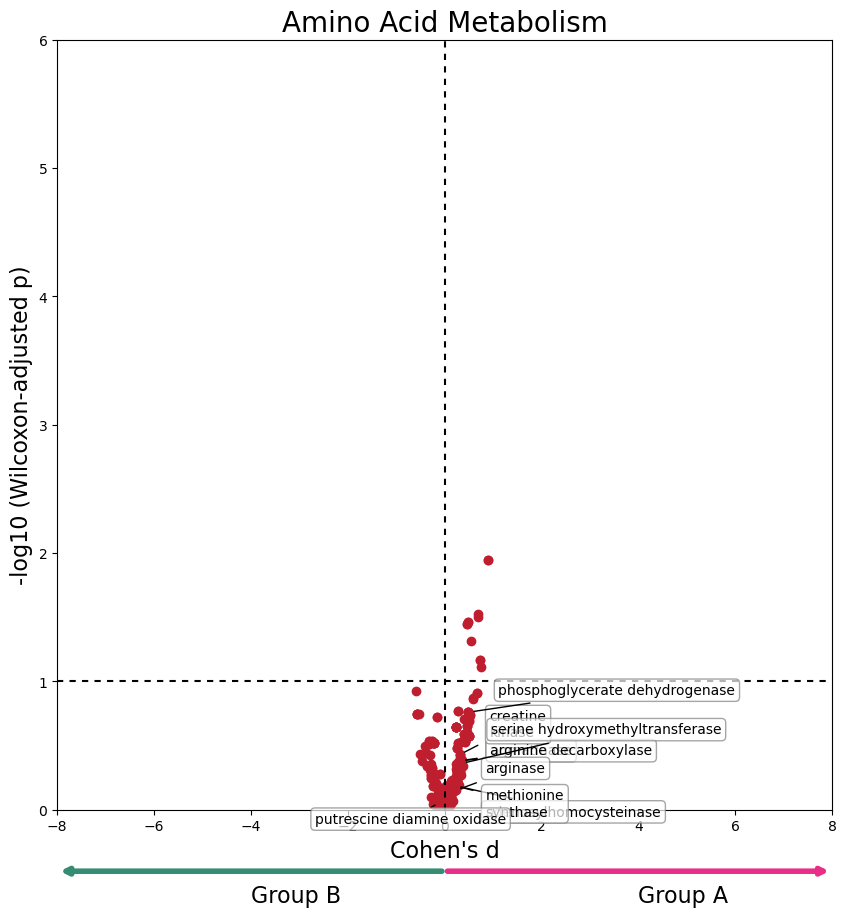

In [73]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

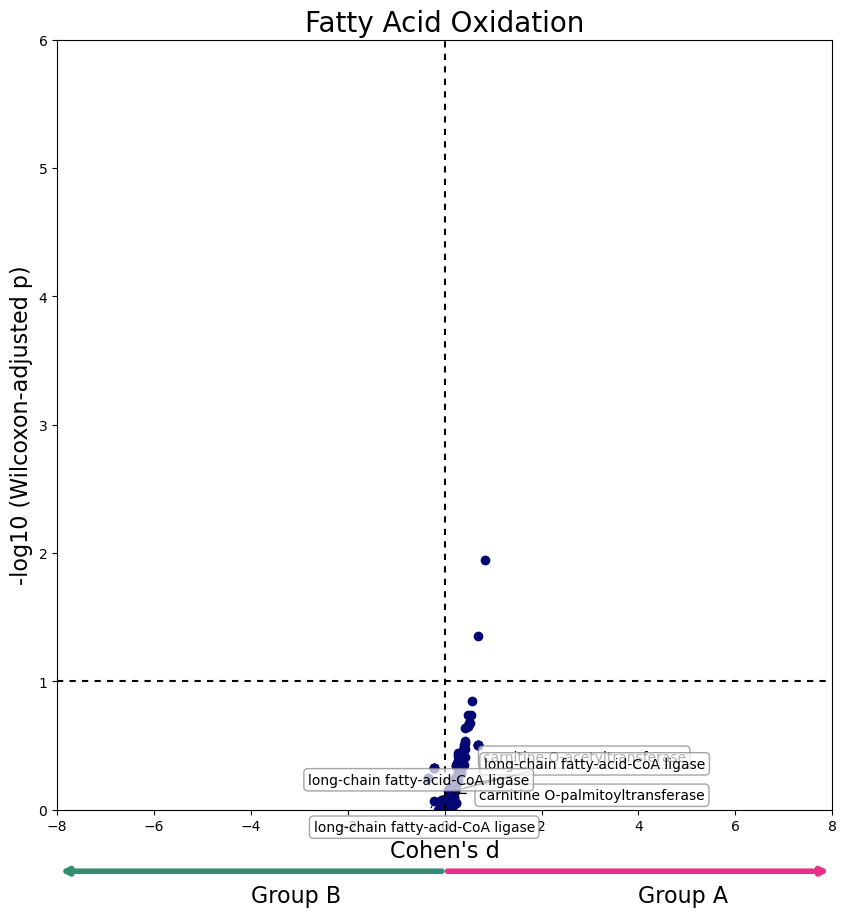

In [74]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

In [75]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 1.0, 'Pathway-Level Differential Activity')

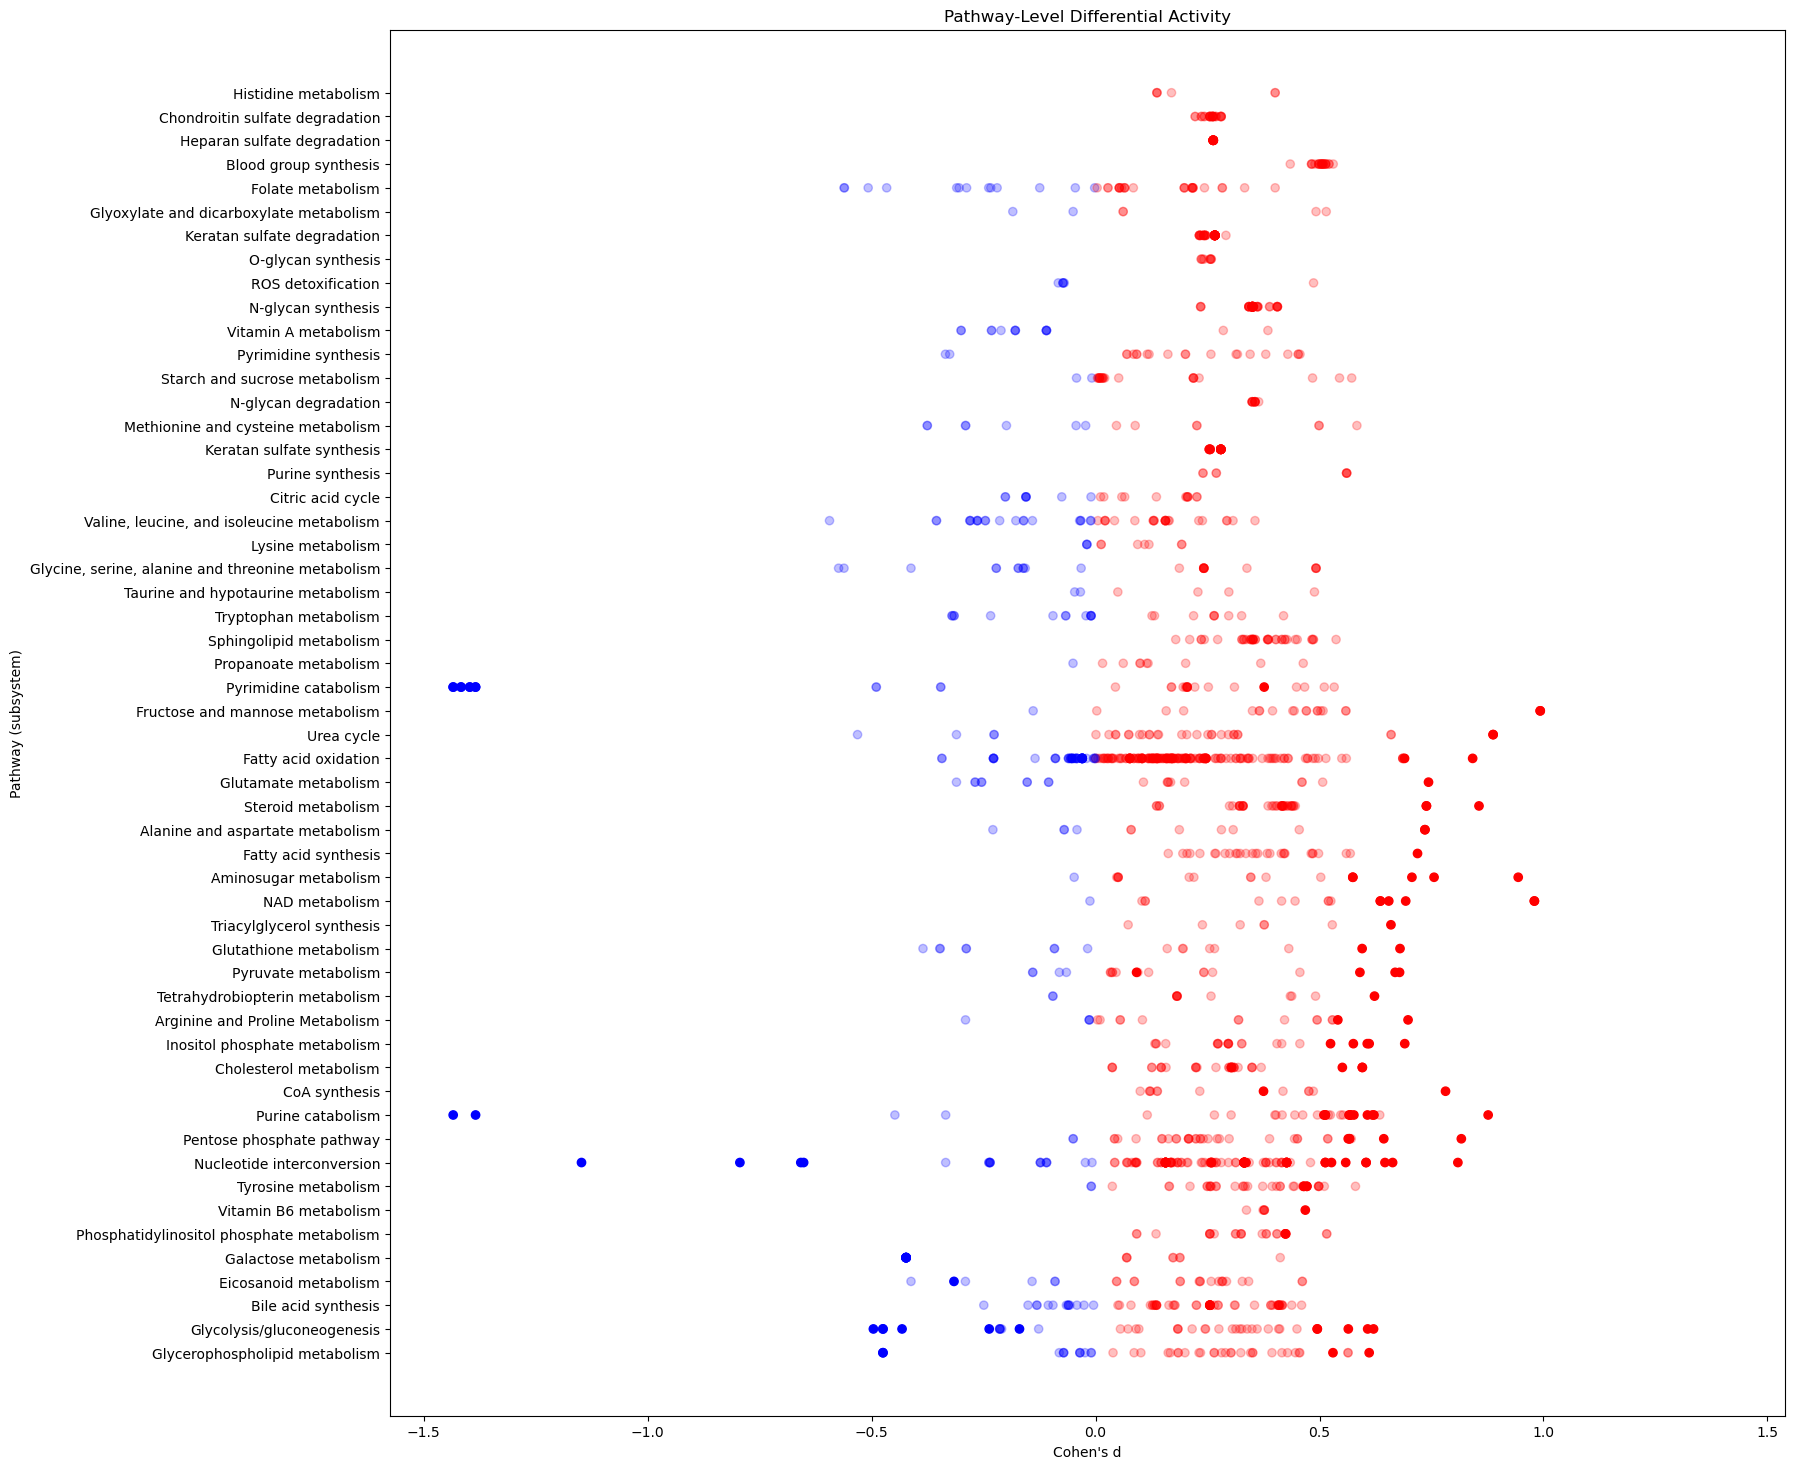

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
axs = plt.gca()

d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()

d_sorted = d.sort_values()

axs.scatter(d_sorted, d_sorted.index, alpha=0)

color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)

axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)

axs.set_xlabel("Cohen's d")
axs.set_ylabel("Pathway (subsystem)")
axs.set_title("Pathway-Level Differential Activity")


In [77]:
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col = 0)
reaction_penalties[reaction_penalties <= 1e-4] = 0
reaction_penalties = reaction_penalties[np.all(reaction_penalties != 0, axis=1)]

In [78]:
reaction_penalties = reaction_penalties[reaction_penalties.max(axis=1) - reaction_penalties.min(axis=1) != 0]

In [79]:
meta_rxns_map = get_metareactions(reaction_penalties)
meta_rxns = reaction_penalties.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reaction_penalties.index)).groupby("meta_rxn_id").mean()

In [80]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [81]:
# Select cells for groups A and B
A_cells = cell_metadata.index[cell_metadata["group"] == "A"]
B_cells = cell_metadata.index[cell_metadata["group"] == "B"]

# Run Wilcoxon test between these two groups
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, A_cells, B_cells)

# Optional: check the top results
print(wilcox_meta_rxn_results.head())

             wilcox_stat  wilcox_pval  cohens_d  adjusted_pval
meta_rxn_id                                                   
1                  555.0     0.299955 -0.115809       0.568492
2                  617.0     0.735364 -0.009657       0.871186
3                  793.0     0.102330  0.241795       0.340901
4                  767.0     0.180005  0.257781       0.449106
5                  751.0     0.245845  0.181715       0.514153


In [82]:
wilcox_meta_rxn_results.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval
meta_rxn_id,,,,
1,555.0,0.299955,-0.115809,0.568492


In [83]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reaction_penalties.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [84]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ""
for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [85]:
wilcox_meta_rxn_expanded.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,722.0,0.404433,0.201554,0.655249,10FTHF5GLUtl


In [86]:
outputs = {
    "wilcox_results.csv": wilcox_results,
    "reaction_consistencies.csv": reaction_consistencies,
    "reaction_metadata.csv": reaction_metadata,
    "wilcox_meta_rxn_results.csv": wilcox_meta_rxn_results,
    "wilcox_meta_rxn_expanded.csv": wilcox_meta_rxn_expanded,
    "final_stats_with_metadata.csv": W,
}

for name, df in outputs.items():
    df.to_csv(name)

In [87]:
import zipfile

with zipfile.ZipFile("A vs B.zip", "w") as zipf:
    for filename in outputs:
        zipf.write(filename)


In [88]:
from IPython.display import FileLink
FileLink("A vs B.zip")

C:\Users\user\Desktop\Harshini\Human dataset_APOB_AIM\4_A vs B\A vs B.zip